In [4]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#!pip install plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import datetime as dt
from datetime import timedelta
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,silhouette_samples
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error,r2_score
import statsmodels.api as sm
from statsmodels.tsa.api import Holt,SimpleExpSmoothing,ExponentialSmoothing
from fbprophet import Prophet
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tsa.stattools import adfuller
!pip install pmdarima
!pip install pyramid
from pmdarima import auto_arima
std=StandardScaler()
#pd.set_option('display.float_format', lambda x: '%.6f' % x)

In [5]:
covid=pd.read_csv("/content/sample_data/TAMILNADU (1).csv")
covid.head()

,date,state,confirmed,new conf,recovered,new rec,dead,new dead,other,tested
0,04-01-2021,Tamil Nadu,889490.0,2817.0,859709.0,1634.0,12738.0,19.0,0.0,19681244.0
1,04-02-2021,Tamil Nadu,892780.0,3290.0,861424.0,1715.0,12750.0,12.0,0.0,19767310.0
2,04-03-2021,Tamil Nadu,896226.0,3446.0,863258.0,1834.0,12764.0,14.0,0.0,19849388.0
3,04-04-2021,Tamil Nadu,899807.0,3581.0,865071.0,1813.0,12778.0,14.0,0.0,19932179.0
4,04-05-2021,Tamil Nadu,903479.0,3672.0,866913.0,1842.0,12789.0,11.0,0.0,20012235.0


In [6]:
print("Size/Shape of the dataset: ",covid.shape)
print("Checking for null values:\n",covid.isnull().sum())
print("Checking Data-type of each column:\n",covid.dtypes)

Size/Shape of the dataset:  (184, 10)
Checking for null values:
 date         1
state        1
confirmed    1
new conf     1
recovered    1
new rec      1
dead         1
new dead     1
other        1
tested       1
dtype: int64
Checking Data-type of each column:
 date          object
state         object
confirmed    float64
new conf     float64
recovered    float64
new rec      float64
dead         float64
new dead     float64
other        float64
tested       float64
dtype: object


In [7]:
covid["date"]=pd.to_datetime(covid["date"])

In [8]:
grouped=covid.groupby(["state","date"]).agg({"confirmed":'sum',"recovered":'sum',"dead":'sum'})
grouped

confirmed  recovered     dead
state      date                                     
Tamil Nadu 2021-04-01   889490.0   859709.0  12738.0
           2021-04-02   892780.0   861424.0  12750.0
           2021-04-03   896226.0   863258.0  12764.0
           2021-04-04   899807.0   865071.0  12778.0
           2021-04-05   903479.0   866913.0  12789.0
...                          ...        ...      ...
           2021-09-26  2657266.0  2604491.0  35490.0
           2021-09-27  2658923.0  2606153.0  35509.0
           2021-09-28  2660553.0  2607796.0  35526.0
           2021-09-29  2662177.0  2609435.0  35550.0
           2021-09-30  2663789.0  2611061.0  35578.0

[183 rows x 3 columns]

In [9]:
grouped["Active Cases"]=grouped["confirmed"]-grouped["recovered"]-grouped["dead"]
grouped["log_confirmed"]=np.log(grouped["confirmed"])
grouped["log_active"]=np.log(grouped["Active Cases"])
grouped

confirmed  recovered  ...  log_confirmed  log_active
state      date                              ...                           
Tamil Nadu 2021-04-01   889490.0   859709.0  ...      13.698404    9.743495
           2021-04-02   892780.0   861424.0  ...      13.702095    9.831239
           2021-04-03   896226.0   863258.0  ...      13.705948    9.913636
           2021-04-04   899807.0   865071.0  ...      13.709936    9.996887
           2021-04-05   903479.0   866913.0  ...      13.714008   10.076474
...                          ...        ...  ...            ...         ...
           2021-09-26  2657266.0  2604491.0  ...      14.792808    9.757594
           2021-09-27  2658923.0  2606153.0  ...      14.793432    9.756205
           2021-09-28  2660553.0  2607796.0  ...      14.794045    9.754465
           2021-09-29  2662177.0  2609435.0  ...      14.794655    9.752199
           2021-09-30  2663789.0  2611061.0  ...      14.795260    9.749753

[183 rows x 6 columns]

In [10]:
#Grouping different types of cases as per the date
datewise=covid.groupby(["date"]).agg({"confirmed":'sum',"recovered":'sum',"dead":'sum'})
datewise["Days Since"]=datewise.index-datewise.index.min()
datewise

,confirmed,recovered,dead,Days Since
date,,,,
2021-04-01,889490.0,859709.0,12738.0,0 days
2021-04-02,892780.0,861424.0,12750.0,1 days
2021-04-03,896226.0,863258.0,12764.0,2 days
2021-04-04,899807.0,865071.0,12778.0,3 days
2021-04-05,903479.0,866913.0,12789.0,4 days
...,...,...,...,...
2021-09-26,2657266.0,2604491.0,35490.0,178 days
2021-09-27,2658923.0,2606153.0,35509.0,179 days
2021-09-28,2660553.0,2607796.0,35526.0,180 days


In [11]:
print("Basic Information")
print("Totol number of countries with Disease Spread: ",len(covid["state"].unique()))
print("Total number of Confirmed Cases around the World: ",datewise["confirmed"].iloc[-1])
print("Total number of Recovered Cases around the World: ",datewise["recovered"].iloc[-1])
print("Total number of Deaths Cases around the World: ",datewise["dead"].iloc[-1])
print("Total number of Active Cases around the World: ",(datewise["confirmed"].iloc[-1]-datewise["recovered"].iloc[-1]-datewise["dead"].iloc[-1]))
print("Total number of Closed Cases around the World: ",datewise["recovered"].iloc[-1]+datewise["dead"].iloc[-1])
print("Approximate number of Confirmed Cases per Day around the World: ",np.round(datewise["confirmed"].iloc[-1]/datewise.shape[0]))
print("Approximate number of Recovered Cases per Day around the World: ",np.round(datewise["recovered"].iloc[-1]/datewise.shape[0]))
print("Approximate number of Death Cases per Day around the World: ",np.round(datewise["dead"].iloc[-1]/datewise.shape[0]))
print("Approximate number of Confirmed Cases per hour around the World: ",np.round(datewise["confirmed"].iloc[-1]/((datewise.shape[0])*24)))
print("Approximate number of Recovered Cases per hour around the World: ",np.round(datewise["recovered"].iloc[-1]/((datewise.shape[0])*24)))
print("Approximate number of Death Cases per hour around the World: ",np.round(datewise["dead"].iloc[-1]/((datewise.shape[0])*24)))
print("Number of Confirmed Cases in last 24 hours: ",datewise["confirmed"].iloc[-1]-datewise["confirmed"].iloc[-2])
print("Number of Recovered Cases in last 24 hours: ",datewise["recovered"].iloc[-1]-datewise["recovered"].iloc[-2])
print("Number of Death Cases in last 24 hours: ",datewise["dead"].iloc[-1]-datewise["dead"].iloc[-2])

Basic Information
Totol number of countries with Disease Spread:  2
Total number of Confirmed Cases around the World:  2663789.0
Total number of Recovered Cases around the World:  2611061.0
Total number of Deaths Cases around the World:  35578.0
Total number of Active Cases around the World:  17150.0
Total number of Closed Cases around the World:  2646639.0
Approximate number of Confirmed Cases per Day around the World:  14556.0
Approximate number of Recovered Cases per Day around the World:  14268.0
Approximate number of Death Cases per Day around the World:  194.0
Approximate number of Confirmed Cases per hour around the World:  607.0
Approximate number of Recovered Cases per hour around the World:  595.0
Approximate number of Death Cases per hour around the World:  8.0
Number of Confirmed Cases in last 24 hours:  1612.0
Number of Recovered Cases in last 24 hours:  1626.0
Number of Death Cases in last 24 hours:  28.0


In [12]:
fig=px.bar(x=datewise.index,y=datewise["confirmed"]-datewise["recovered"]-datewise["dead"])
fig.update_layout(title="Distribution of Number of Active Cases",
                  xaxis_title="Date",yaxis_title="Number of Cases",)
fig.show()

In [13]:
fig=px.bar(x=datewise.index,y=datewise["recovered"]+datewise["dead"])
fig.update_layout(title="Distribution of Number of Closed Cases",
                  xaxis_title="Date",yaxis_title="Number of Cases")
fig.show()

In [14]:
datewise["WeekOfYear"]=datewise.index.weekofyear

week_num=[]
weekwise_confirmed=[]
weekwise_recovered=[]
weekwise_deaths=[]
w=1
for i in list(datewise["WeekOfYear"].unique()):
    weekwise_confirmed.append(datewise[datewise["WeekOfYear"]==i]["confirmed"].iloc[-1])
    weekwise_recovered.append(datewise[datewise["WeekOfYear"]==i]["recovered"].iloc[-1])
    weekwise_deaths.append(datewise[datewise["WeekOfYear"]==i]["dead"].iloc[-1])
    week_num.append(w)
    w=w+1

fig=go.Figure()
fig.add_trace(go.Scatter(x=week_num, y=weekwise_confirmed,
                    mode='lines+markers',
                    name='Weekly Growth of Confirmed Cases'))
fig.add_trace(go.Scatter(x=week_num, y=weekwise_recovered,
                    mode='lines+markers',
                    name='Weekly Growth of Recovered Cases'))
fig.add_trace(go.Scatter(x=week_num, y=weekwise_deaths,
                    mode='lines+markers',
                    name='Weekly Growth of Death Cases'))
fig.update_layout(title="Weekly Growth of different types of Cases in Tamil Nadu",
                 xaxis_title="Week Number",yaxis_title="Number of Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

Text(0.5, 1.0, 'Weekly increase in Number of Death Cases')

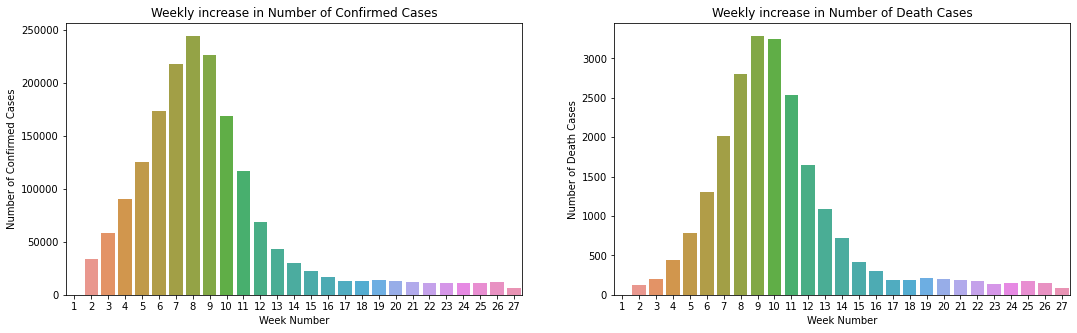

In [15]:
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(18,5))
sns.barplot(x=week_num,y=pd.Series(weekwise_confirmed).diff().fillna(0),ax=ax1)
sns.barplot(x=week_num,y=pd.Series(weekwise_deaths).diff().fillna(0),ax=ax2)
ax1.set_xlabel("Week Number")
ax2.set_xlabel("Week Number")
ax1.set_ylabel("Number of Confirmed Cases")
ax2.set_ylabel("Number of Death Cases")
ax1.set_title("Weekly increase in Number of Confirmed Cases")
ax2.set_title("Weekly increase in Number of Death Cases")

GROWTH RATE OF TAMIL NADU


In [16]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["confirmed"],
                    mode='lines+markers',
                    name='Confirmed Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["recovered"],
                    mode='lines+markers',
                    name='Recovered Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["dead"],
                    mode='lines+markers',
                    name='Death Cases'))
fig.update_layout(title="Growth of different types of cases",
                 xaxis_title="Date",yaxis_title="Number of Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [17]:
#Calculating the Mortality Rate and Recovery Rate
datewise["Mortality Rate"]=(datewise["dead"]/datewise["confirmed"])*100
datewise["Recovery Rate"]=(datewise["recovered"]/datewise["confirmed"])*100
datewise["Active Cases"]=datewise["confirmed"]-datewise["recovered"]-datewise["dead"]
datewise["Closed Cases"]=datewise["recovered"]+datewise["dead"]

print("Average Mortality Rate",datewise["Mortality Rate"].mean())
print("Median Mortality Rate",datewise["Mortality Rate"].median())
print("Average Recovery Rate",datewise["Recovery Rate"].mean())
print("Median Recovery Rate",datewise["Recovery Rate"].median())

#Plotting Mortality and Recovery Rate 
fig = make_subplots(rows=2, cols=1,
                   subplot_titles=("Recovery Rate", "Mortatlity Rate"))
fig.add_trace(
    go.Scatter(x=datewise.index, y=(datewise["recovered"]/datewise["confirmed"])*100,name="Recovery Rate"),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=datewise.index, y=(datewise["dead"]/datewise["confirmed"])*100,name="Mortality Rate"),
    row=2, col=1
)
fig.update_layout(height=1000,legend=dict(x=-0.1,y=1.2,traceorder="normal"))
fig.update_xaxes(title_text="Date", row=1, col=1)
fig.update_yaxes(title_text="Recovery Rate", row=1, col=1)
fig.update_xaxes(title_text="Date", row=1, col=2)
fig.update_yaxes(title_text="Mortality Rate", row=1, col=2)
fig.show()

Average Mortality Rate 1.2865367195204769
Median Mortality Rate 1.3301243747539837
Average Recovery Rate 94.06300245209003
Median Recovery Rate 97.17222243020525


In [18]:
datewise


,confirmed,recovered,dead,Days Since,WeekOfYear,Mortality Rate,Recovery Rate,Active Cases,Closed Cases
date,,,,,,,,,
2021-04-01,889490.0,859709.0,12738.0,0 days,13,1.432057,96.651902,17043.0,872447.0
2021-04-02,892780.0,861424.0,12750.0,1 days,13,1.428123,96.487825,18606.0,874174.0
2021-04-03,896226.0,863258.0,12764.0,2 days,13,1.424194,96.321464,20204.0,876022.0
2021-04-04,899807.0,865071.0,12778.0,3 days,13,1.420082,96.139617,21958.0,877849.0
2021-04-05,903479.0,866913.0,12789.0,4 days,14,1.415528,95.952756,23777.0,879702.0
...,...,...,...,...,...,...,...,...,...
2021-09-26,2657266.0,2604491.0,35490.0,178 days,38,1.335583,98.013936,17285.0,2639981.0
2021-09-27,2658923.0,2606153.0,35509.0,179 days,39,1.335466,98.015362,17261.0,2641662.0
2021-09-28,2660553.0,2607796.0,35526.0,180 days,39,1.335286,98.017066,17231.0,2643322.0


In [19]:
print("Average increase in number of Confirmed Cases every day: ",np.round(datewise["confirmed"].diff().fillna(0).mean()))
print("Average increase in number of Recovered Cases every day: ",np.round(datewise["recovered"].diff().fillna(0).mean()))
print("Average increase in number of Deaths Cases every day: ",np.round(datewise["dead"].diff().fillna(0).mean()))

fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["confirmed"].diff().fillna(0),mode='lines+markers',
                    name='Confirmed Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["recovered"].diff().fillna(0),mode='lines+markers',
                    name='Recovered Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["dead"].diff().fillna(0),mode='lines+markers',
                    name='Death Cases'))
fig.update_layout(title="Daily increase in different types of Cases",
                 xaxis_title="Date",yaxis_title="Number of Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

Average increase in number of Confirmed Cases every day:  9696.0
Average increase in number of Recovered Cases every day:  9570.0
Average increase in number of Deaths Cases every day:  125.0


In [20]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["confirmed"].diff().rolling(window=7).mean(),mode='lines+markers',
                    name='Confirmed Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["recovered"].diff().rolling(window=7).mean(),mode='lines+markers',
                    name='Recovered Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["dead"].diff().rolling(window=7).mean(),mode='lines+markers',
                    name='Death Cases'))
fig.update_layout(title="7 Days Rolling Mean of Daily Increase of Confirmed, Recovered and Death Cases",
                 xaxis_title="Date",yaxis_title="Number of Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

GROWTH FACTOR


In [21]:
print("Average growth factor of number of Confirmed Cases: ",(datewise["confirmed"]/datewise["confirmed"].shift()).mean())
print("Median growth factor of number of Confirmed Cases: ",(datewise["confirmed"]/datewise["confirmed"].shift()).median())
print("Average growth factor of number of Recovered Cases: ",(datewise["recovered"]/datewise["recovered"].shift()).mean())
print("Median growth factor of number of Recovered Cases: ",(datewise["recovered"]/datewise["recovered"].shift()).median())
print("Average growth factor of number of Death Cases: ",(datewise["dead"]/datewise["dead"].shift()).mean())
print("Median growth factor of number of Death Cases: ",(datewise["dead"]/datewise["dead"].shift()).median())

fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["confirmed"]/datewise["confirmed"].shift(),
                    mode='lines',
                    name='Growth Factor of Confirmed Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["recovered"]/datewise["recovered"].shift(),
                    mode='lines',
                    name='Growth Factor of Recovered Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["dead"]/datewise["dead"].shift(),
                    mode='lines',
                    name='Growth Factor of Death Cases'))
fig.update_layout(title="Datewise Growth Factor of different types of cases",
                 xaxis_title="Date",yaxis_title="Growth Factor",
                 legend=dict(x=0,y=-0.4,traceorder="normal"))
fig.show()

Average growth factor of number of Confirmed Cases:  1.006069734825774
Median growth factor of number of Confirmed Cases:  1.0017549267844301
Average growth factor of number of Recovered Cases:  1.0061461023330702
Median growth factor of number of Recovered Cases:  1.0020231437818872
Average growth factor of number of Death Cases:  1.0056837365728135
Median growth factor of number of Death Cases:  1.0015590297130896


In [22]:
R0=datewise["confirmed"]/datewise["confirmed"].shift()
R0

date
2021-04-01         NaN
2021-04-02    1.003699
2021-04-03    1.003860
2021-04-04    1.003996
2021-04-05    1.004081
                ...   
2021-09-26    1.000638
2021-09-27    1.000624
2021-09-28    1.000613
2021-09-29    1.000610
2021-09-30    1.000606
Name: confirmed, Length: 183, dtype: float64

In [23]:
#growth factor for active and closed cases
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, 
                         y=(datewise["confirmed"]-datewise["recovered"]-datewise["dead"])/(datewise["confirmed"]-datewise["recovered"]-datewise["dead"]).shift(),
                    mode='lines',
                    name='Growth Factor of Active Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=(datewise["recovered"]+datewise["dead"])/(datewise["recovered"]+datewise["dead"]).shift(),
                    mode='lines',
                    name='Growth Factor of Closed Cases'))
fig.update_layout(title="Datewise Growth Factor of Active and Closed Cases",
                 xaxis_title="Date",yaxis_title="Growth Factor",
                 legend=dict(x=0,y=-0.4,traceorder="normal"))
fig.show()

In [24]:
#linear regression


In [25]:
datewise["Days Since"]=datewise.index-datewise.index[0]
datewise["Days Since"]=datewise["Days Since"].dt.days

In [26]:
train_ml=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid_ml=datewise.iloc[int(datewise.shape[0]*0.95):]
model_scores=[]

In [27]:
lin_reg=LinearRegression(normalize=True)

In [28]:
lin_reg.fit(np.array(train_ml["Days Since"]).reshape(-1,1),np.array(train_ml["confirmed"]).reshape(-1,1))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [29]:
prediction_valid_linreg=lin_reg.predict(np.array(valid_ml["Days Since"]).reshape(-1,1))

In [30]:
model_scores.append(np.sqrt(mean_squared_error(valid_ml["confirmed"],prediction_valid_linreg)))
print("Root Mean Square Error for Linear Regression: ",np.sqrt(mean_squared_error(valid_ml["confirmed"],prediction_valid_linreg)))

Root Mean Square Error for Linear Regression:  475627.37805170205


In [31]:
plt.figure(figsize=(11,6))
prediction_linreg=lin_reg.predict(np.array(datewise["Days Since"]).reshape(-1,1))
linreg_output=[]
for i in range(prediction_linreg.shape[0]):
    linreg_output.append(prediction_linreg[i][0])

fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=datewise.index, y=linreg_output,
                    mode='lines',name="Linear Regression Best Fit Line",
                    line=dict(color='black', dash='dot')))
fig.update_layout(title="Confirmed Cases Linear Regression Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

<Figure size 792x432 with 0 Axes>

In [32]:
#polynomial regression 
train_ml=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid_ml=datewise.iloc[int(datewise.shape[0]*0.95):]
poly = PolynomialFeatures(degree = 8) 

In [33]:
train_poly=poly.fit_transform(np.array(train_ml["Days Since"]).reshape(-1,1))
valid_poly=poly.fit_transform(np.array(valid_ml["Days Since"]).reshape(-1,1))
y=train_ml["confirmed"]

In [34]:
linreg=LinearRegression(normalize=True)
linreg.fit(train_poly,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [35]:
prediction_poly=linreg.predict(valid_poly)
rmse_poly=np.sqrt(mean_squared_error(valid_ml["confirmed"],prediction_poly))
model_scores=[]
model_scores.append(rmse_poly)
print("Root Mean Squared Error for Polynomial Regression: ",rmse_poly)

Root Mean Squared Error for Polynomial Regression:  62082.6374825394


In [36]:
comp_data=poly.fit_transform(np.array(datewise["Days Since"]).reshape(-1,1))
plt.figure(figsize=(11,6))
predictions_poly=linreg.predict(comp_data)

fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=datewise.index, y=predictions_poly,
                    mode='lines',name="Polynomial Regression Best Fit",
                    line=dict(color='black', dash='dot')))
fig.update_layout(title="Confirmed Cases Polynomial Regression Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",
                 legend=dict(x=0,y=1,traceorder="normal"))
fig.show()


<Figure size 792x432 with 0 Axes>

SVM PREDICTION

In [37]:
train_ml=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid_ml=datewise.iloc[int(datewise.shape[0]*0.95):]

In [38]:
#Intializing SVR Model
svm=SVR(C=1,degree=6,kernel='poly',epsilon=0.01)

In [39]:
#Fitting model on the training data
svm.fit(np.array(train_ml["Days Since"]).reshape(-1,1),np.array(train_ml["confirmed"]).reshape(-1,1))

SVR(C=1, cache_size=200, coef0=0.0, degree=6, epsilon=0.01, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [40]:
prediction_valid_svm=svm.predict(np.array(valid_ml["Days Since"]).reshape(-1,1))

In [41]:
model_scores.append(np.sqrt(mean_squared_error(valid_ml["confirmed"],prediction_valid_svm)))
print("Root Mean Square Error for Support Vectore Machine: ",np.sqrt(mean_squared_error(valid_ml["confirmed"],prediction_valid_svm)))

Root Mean Square Error for Support Vectore Machine:  341361.58314840664


In [42]:
plt.figure(figsize=(11,6))
prediction_svm=svm.predict(np.array(datewise["Days Since"]).reshape(-1,1))
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=datewise.index, y=prediction_svm,
                    mode='lines',name="Support Vector Machine Best fit Kernel",
                    line=dict(color='black', dash='dot')))
fig.update_layout(title="Confirmed Cases Support Vectore Machine Regressor Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

<Figure size 792x432 with 0 Axes>

In [43]:
#new polynomial
new_prediction_poly=[]
for i in range(1,18):
    new_date_poly=poly.fit_transform(np.array(datewise["Days Since"].max()+i).reshape(-1,1))
    new_prediction_poly.append(linreg.predict(new_date_poly)[0])

In [44]:
#new svm prediction
new_date=[]
new_prediction_svm=[]
for i in range(1,18):
    new_date.append(datewise.index[-1]+timedelta(days=i))
    new_prediction_svm.append(svm.predict(np.array(datewise["Days Since"].max()+i).reshape(-1,1))[0])

In [45]:
pd.set_option('display.float_format', lambda x: '%.6f' % x)
model_predictions=pd.DataFrame(zip(new_date,new_prediction_poly,new_prediction_svm),
                               columns=["Dates","Polynonmial Regression Prediction","SVM Prediction"])
model_predictions

,Dates,Polynonmial Regression Prediction,SVM Prediction
0,2021-10-01,2790667.824792,3126653.711300
1,2021-10-02,2810938.256568,3153921.743166
2,2021-10-03,2832870.385761,3181940.908003
3,2021-10-04,2856525.658274,3210727.668144
4,2021-10-05,2881961.437666,3240298.755051
5,2021-10-06,2909230.310603,3270671.172234
6,2021-10-07,2938379.349916,3301862.198184
7,2021-10-08,2969449.333930,3333889.389317
8,2021-10-09,3002473.920782,3366770.582947
9,2021-10-10,3037478.776350,3400523.900260


FORECASTING

HOLT'S LINEAR MODEL

In [46]:
model_train=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid=datewise.iloc[int(datewise.shape[0]*0.95):]
y_pred=valid.copy()

In [47]:
holt=Holt(np.asarray(model_train["confirmed"])).fit(smoothing_level=0.4, smoothing_slope=0.4,optimized=False)     

In [48]:
y_pred["Holt"]=holt.forecast(10)
model_scores.append(np.sqrt(mean_squared_error(y_pred["confirmed"],y_pred["Holt"])))
print("Root Mean Square Error Holt's Linear Model: ",np.sqrt(mean_squared_error(y_pred["confirmed"],y_pred["Holt"])))

Root Mean Square Error Holt's Linear Model:  120.17128969212175


In [49]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["Holt"],
                    mode='lines+markers',name="Prediction of Confirmed Cases",))
fig.update_layout(title="Confirmed Cases Holt's Linear Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [50]:
#holt new prediction
holt_new_date=[]
holt_new_prediction=[]
for i in range(1,18):
    holt_new_date.append(datewise.index[-1]+timedelta(days=i))
    holt_new_prediction.append(holt.forecast((len(valid)+i))[-1])

model_predictions["Holt's Linear Model Prediction"]=holt_new_prediction
model_predictions

,Dates,Polynonmial Regression Prediction,SVM Prediction,Holt's Linear Model Prediction
0,2021-10-01,2790667.824792,3126653.711300,2665449.439156
1,2021-10-02,2810938.256568,3153921.743166,2667125.021256
2,2021-10-03,2832870.385761,3181940.908003,2668800.603355
3,2021-10-04,2856525.658274,3210727.668144,2670476.185455
4,2021-10-05,2881961.437666,3240298.755051,2672151.767555
5,2021-10-06,2909230.310603,3270671.172234,2673827.349655
6,2021-10-07,2938379.349916,3301862.198184,2675502.931754
7,2021-10-08,2969449.333930,3333889.389317,2677178.513854
8,2021-10-09,3002473.920782,3366770.582947,2678854.095954
9,2021-10-10,3037478.776350,3400523.900260,2680529.678054


HOLT'S WINTER MODEL

In [51]:
model_train=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid=datewise.iloc[int(datewise.shape[0]*0.95):]
y_pred=valid.copy()

In [52]:
es=ExponentialSmoothing(np.asarray(model_train['confirmed']),seasonal_periods=14,trend='add', seasonal='mul').fit()

In [53]:
y_pred["Holt's Winter Model"]=es.forecast(len(valid))
model_scores.append(np.sqrt(mean_squared_error(y_pred["confirmed"],y_pred["Holt's Winter Model"])))
print("Root Mean Square Error for Holt's Winter Model: ",np.sqrt(mean_squared_error(y_pred["confirmed"],y_pred["Holt's Winter Model"])))

Root Mean Square Error for Holt's Winter Model:  968.7243911546766


In [54]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["Holt\'s Winter Model"],
                    mode='lines+markers',name="Prediction of Confirmed Cases",))
fig.update_layout(title="Confirmed Cases Holt's Winter Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [55]:
#holt winter new prediction
holt_winter_new_prediction=[]
for i in range(1,18):
    holt_winter_new_prediction.append(es.forecast((len(valid)+i))[-1])
model_predictions["Holt's Winter Model Prediction"]=holt_winter_new_prediction
model_predictions.head()

,Dates,Polynonmial Regression Prediction,SVM Prediction,Holt's Linear Model Prediction,Holt's Winter Model Prediction
0,2021-10-01,2790667.824792,3126653.711300,2665449.439156,2664612.694620
1,2021-10-02,2810938.256568,3153921.743166,2667125.021256,2666248.865046
2,2021-10-03,2832870.385761,3181940.908003,2668800.603355,2667877.559075
3,2021-10-04,2856525.658274,3210727.668144,2670476.185455,2669178.131616
4,2021-10-05,2881961.437666,3240298.755051,2672151.767555,2670636.348595


In [56]:
model_train=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid=datewise.iloc[int(datewise.shape[0]*0.95):]
y_pred=valid.copy()

AR MODEL (AUTO ARIMA)

In [57]:
model_ar= auto_arima(model_train["confirmed"],trace=True, error_action='ignore', start_p=0,start_q=0,max_p=4,max_q=0,
                   suppress_warnings=True,stepwise=False,seasonal=False)
model_ar.fit(model_train["confirmed"])

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2706.896, Time=0.07 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=2708.884, Time=0.09 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=2710.828, Time=0.21 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=2712.725, Time=0.39 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=2714.460, Time=0.48 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0] intercept
Total fit time: 1.238 seconds


ARIMA(maxiter=50, method='lbfgs', order=(0, 2, 0), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [58]:
prediction_ar=model_ar.predict(len(valid))
y_pred["AR Model Prediction"]=prediction_ar

In [59]:
model_scores.append(np.sqrt(mean_squared_error(y_pred["confirmed"],y_pred["AR Model Prediction"])))
print("Root Mean Square Error for AR Model: ",np.sqrt(mean_squared_error(y_pred["confirmed"],y_pred["AR Model Prediction"])))

Root Mean Square Error for AR Model:  429.8405701991814


In [60]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["AR Model Prediction"],
                    mode='lines+markers',name="Prediction of Confirmed Cases",))
fig.update_layout(title="Confirmed Cases AR Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [61]:
#ar model new prediction
AR_model_new_prediction=[]
for i in range(1,18):
    AR_model_new_prediction.append(model_ar.predict(len(valid)+i)[-1])
model_predictions["AR Model Prediction"]=AR_model_new_prediction
model_predictions.head()

,Dates,Polynonmial Regression Prediction,SVM Prediction,Holt's Linear Model Prediction,Holt's Winter Model Prediction,AR Model Prediction
0,2021-10-01,2790667.824792,3126653.711300,2665449.439156,2664612.694620,2664683.263158
1,2021-10-02,2810938.256568,3153921.743166,2667125.021256,2666248.865046,2666229.947368
2,2021-10-03,2832870.385761,3181940.908003,2668800.603355,2667877.559075,2667767.105263
3,2021-10-04,2856525.658274,3210727.668144,2670476.185455,2669178.131616,2669294.736842
4,2021-10-05,2881961.437666,3240298.755051,2672151.767555,2670636.348595,2670812.842105


MA MODEL (AUTO ARIMA)

In [62]:
model_train=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid=datewise.iloc[int(datewise.shape[0]*0.95):]
y_pred=valid.copy()

In [63]:
model_ma= auto_arima(model_train["confirmed"],trace=True, error_action='ignore', start_p=0,start_q=0,max_p=0,max_q=2,
                   suppress_warnings=True,stepwise=False,seasonal=False)
model_ma.fit(model_train["confirmed"])

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2706.896, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=2709.705, Time=0.10 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=2711.337, Time=0.10 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0] intercept
Total fit time: 0.212 seconds


ARIMA(maxiter=50, method='lbfgs', order=(0, 2, 0), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [64]:
prediction_ma=model_ma.predict(len(valid))
y_pred["MA Model Prediction"]=prediction_ma

In [65]:
model_scores.append(np.sqrt(mean_squared_error(valid["confirmed"],prediction_ma)))
print("Root Mean Square Error for MA Model: ",np.sqrt(mean_squared_error(valid["confirmed"],prediction_ma)))

Root Mean Square Error for MA Model:  429.8405701991814


In [66]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["MA Model Prediction"],
                    mode='lines+markers',name="Prediction for Confirmed Cases",))
fig.update_layout(title="Confirmed Cases MA Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [67]:
#ma model new prediction
MA_model_new_prediction=[]
for i in range(1,18):
    MA_model_new_prediction.append(model_ma.predict(len(valid)+i)[-1])
model_predictions["MA Model Prediction"]=MA_model_new_prediction
model_predictions.head()

,Dates,Polynonmial Regression Prediction,SVM Prediction,Holt's Linear Model Prediction,Holt's Winter Model Prediction,AR Model Prediction,MA Model Prediction
0,2021-10-01,2790667.824792,3126653.711300,2665449.439156,2664612.694620,2664683.263158,2664683.263158
1,2021-10-02,2810938.256568,3153921.743166,2667125.021256,2666248.865046,2666229.947368,2666229.947368
2,2021-10-03,2832870.385761,3181940.908003,2668800.603355,2667877.559075,2667767.105263,2667767.105263
3,2021-10-04,2856525.658274,3210727.668144,2670476.185455,2669178.131616,2669294.736842,2669294.736842
4,2021-10-05,2881961.437666,3240298.755051,2672151.767555,2670636.348595,2670812.842105,2670812.842105


ARIMA MODEL (AUTO ARIMA)

In [68]:
model_train=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid=datewise.iloc[int(datewise.shape[0]*0.95):]
y_pred=valid.copy()

In [69]:
model_arima= auto_arima(model_train["confirmed"],trace=True, error_action='ignore', start_p=1,start_q=1,max_p=3,max_q=3,
                   suppress_warnings=True,stepwise=False,seasonal=False)
model_arima.fit(model_train["confirmed"])

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2706.896, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=2709.705, Time=0.10 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=2711.337, Time=0.08 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=2713.175, Time=0.25 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=2708.884, Time=0.14 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=2768.445, Time=0.53 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=2785.438, Time=0.59 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=2710.828, Time=0.19 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=2808.796, Time=0.57 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=2755.972, Time=0.63 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.77 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=2712.725, Time=0.32 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=2714.743, Time=0.73 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=2847.989, Time=0.38 sec

Best model:  ARIMA(

ARIMA(maxiter=50, method='lbfgs', order=(0, 2, 0), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [70]:
prediction_arima=model_arima.predict(len(valid))
y_pred["ARIMA Model Prediction"]=prediction_arima

In [71]:
model_scores.append(np.sqrt(mean_squared_error(valid["confirmed"],prediction_arima)))
print("Root Mean Square Error for ARIMA Model: ",np.sqrt(mean_squared_error(valid["confirmed"],prediction_arima)))

Root Mean Square Error for ARIMA Model:  429.8405701991814


In [72]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["ARIMA Model Prediction"],
                    mode='lines+markers',name="Prediction for Confirmed Cases",))
fig.update_layout(title="Confirmed Cases ARIMA Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [73]:
ARIMA_model_new_prediction=[]
for i in range(1,18):
    ARIMA_model_new_prediction.append(model_arima.predict(len(valid)+i)[-1])
model_predictions["ARIMA Model Prediction"]=ARIMA_model_new_prediction
model_predictions.head()

,Dates,Polynonmial Regression Prediction,SVM Prediction,Holt's Linear Model Prediction,Holt's Winter Model Prediction,AR Model Prediction,MA Model Prediction,ARIMA Model Prediction
0,2021-10-01,2790667.824792,3126653.711300,2665449.439156,2664612.694620,2664683.263158,2664683.263158,2664683.263158
1,2021-10-02,2810938.256568,3153921.743166,2667125.021256,2666248.865046,2666229.947368,2666229.947368,2666229.947368
2,2021-10-03,2832870.385761,3181940.908003,2668800.603355,2667877.559075,2667767.105263,2667767.105263,2667767.105263
3,2021-10-04,2856525.658274,3210727.668144,2670476.185455,2669178.131616,2669294.736842,2669294.736842,2669294.736842
4,2021-10-05,2881961.437666,3240298.755051,2672151.767555,2670636.348595,2670812.842105,2670812.842105,2670812.842105


SARIMA MODEL (AUTO ARIMA)

In [74]:
model_sarima= auto_arima(model_train["confirmed"],trace=True, error_action='ignore', 
                         start_p=0,start_q=0,max_p=2,max_q=2,m=7,
                   suppress_warnings=True,stepwise=True,seasonal=True)
model_sarima.fit(model_train["confirmed"])

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,0,1)[7]             : AIC=2746.701, Time=0.39 sec
 ARIMA(0,2,0)(0,0,0)[7]             : AIC=2704.932, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[7]             : AIC=2707.370, Time=0.25 sec
 ARIMA(0,2,1)(0,0,1)[7]             : AIC=2707.367, Time=0.20 sec
 ARIMA(0,2,0)(1,0,0)[7]             : AIC=2705.392, Time=0.11 sec
 ARIMA(0,2,0)(0,0,1)[7]             : AIC=2706.133, Time=0.09 sec
 ARIMA(1,2,0)(0,0,0)[7]             : AIC=2706.911, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[7]             : AIC=2707.734, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[7]             : AIC=2801.458, Time=0.13 sec
 ARIMA(0,2,0)(0,0,0)[7] intercept   : AIC=2706.896, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[7]          
Total fit time: 1.328 seconds


ARIMA(maxiter=50, method='lbfgs', order=(0, 2, 0), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 0, 7),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)

In [75]:
prediction_sarima=model_sarima.predict(len(valid))
y_pred["SARIMA Model Prediction"]=prediction_sarima

In [76]:
model_scores.append(np.sqrt(mean_squared_error(y_pred["confirmed"],y_pred["SARIMA Model Prediction"])))
print("Root Mean Square Error for SARIMA Model: ",np.sqrt(mean_squared_error(y_pred["confirmed"],y_pred["SARIMA Model Prediction"])))

Root Mean Square Error for SARIMA Model:  179.57338332837637


In [77]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["SARIMA Model Prediction"],
                    mode='lines+markers',name="Prediction for Confirmed Cases",))
fig.update_layout(title="Confirmed Cases SARIMA Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [78]:
SARIMA_model_new_prediction=[]
for i in range(1,18):
    SARIMA_model_new_prediction.append(model_sarima.predict(len(valid)+i)[-1])
model_predictions["SARIMA Model Prediction"]=SARIMA_model_new_prediction
model_predictions.head()

,Dates,Polynonmial Regression Prediction,SVM Prediction,Holt's Linear Model Prediction,Holt's Winter Model Prediction,AR Model Prediction,MA Model Prediction,ARIMA Model Prediction,SARIMA Model Prediction
0,2021-10-01,2790667.824792,3126653.711300,2665449.439156,2664612.694620,2664683.263158,2664683.263158,2664683.263158,2665312.000000
1,2021-10-02,2810938.256568,3153921.743166,2667125.021256,2666248.865046,2666229.947368,2666229.947368,2666229.947368,2666973.000000
2,2021-10-03,2832870.385761,3181940.908003,2668800.603355,2667877.559075,2667767.105263,2667767.105263,2667767.105263,2668634.000000
3,2021-10-04,2856525.658274,3210727.668144,2670476.185455,2669178.131616,2669294.736842,2669294.736842,2669294.736842,2670295.000000
4,2021-10-05,2881961.437666,3240298.755051,2672151.767555,2670636.348595,2670812.842105,2670812.842105,2670812.842105,2671956.000000


FB PROPHET

In [79]:
prophet_c=Prophet(interval_width=0.95,weekly_seasonality=True,)
prophet_confirmed=pd.DataFrame(zip(list(datewise.index),list(datewise["confirmed"])),columns=['ds','y'])

In [80]:
prophet_c.fit(prophet_confirmed)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [81]:
forecast_c=prophet_c.make_future_dataframe(periods=17)
forecast_confirmed=forecast_c.copy()

In [82]:
confirmed_forecast=prophet_c.predict(forecast_c)
#i]k,print(confirmed_forecast[['ds','yhat', 'yhat_lower', 'yhat_upper']])

In [83]:
model_scores.append(np.sqrt(mean_squared_error(datewise["confirmed"],confirmed_forecast['yhat'].head(datewise.shape[0]))))
print("Root Mean Squared Error for Prophet Model: ",np.sqrt(mean_squared_error(datewise["confirmed"],confirmed_forecast['yhat'].head(datewise.shape[0]))))

Root Mean Squared Error for Prophet Model:  846.5566668633784


Figure(720x432)


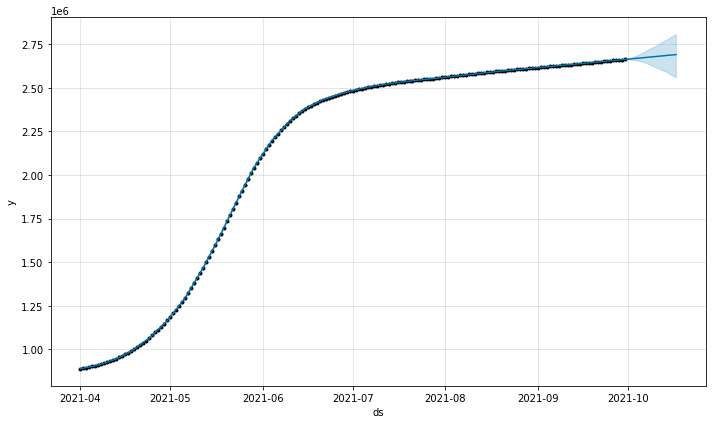

In [84]:
print(prophet_c.plot(confirmed_forecast))

Figure(648x432)


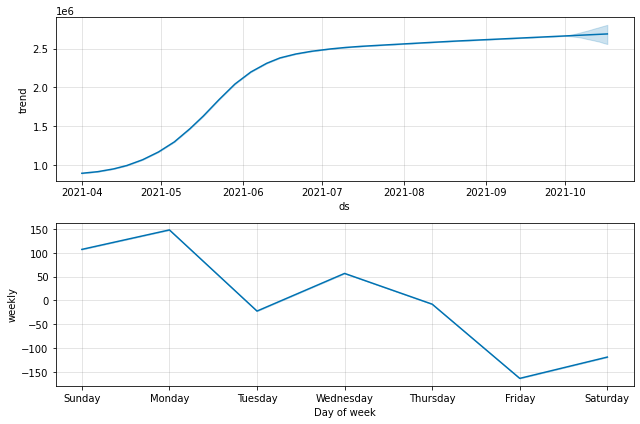

In [85]:
print(prophet_c.plot_components(confirmed_forecast))

In [86]:
model_names=["Polynomial Regression","Support Vector Machine Regressor","Holt's Linear","Holt's Winter Model",
            "Auto Regressive Model (AR)","Moving Average Model (MA)","ARIMA Model","SARIMA Model","Facebook's Prophet Model"]
model_summary=pd.DataFrame(zip(model_names,model_scores),columns=["Model Name","Root Mean Squared Error"]).sort_values(["Root Mean Squared Error"])
model_summary

,Model Name,Root Mean Squared Error
2,Holt's Linear,120.171290
7,SARIMA Model,179.573383
4,Auto Regressive Model (AR),429.840570
5,Moving Average Model (MA),429.840570
6,ARIMA Model,429.840570
8,Facebook's Prophet Model,846.556667
3,Holt's Winter Model,968.724391
0,Polynomial Regression,62082.637483
1,Support Vector Machine Regressor,341361.583148


In [87]:
model_predictions["Prophet's Prediction"]=list(confirmed_forecast["yhat"].tail(17))
model_predictions["Prophet's Upper Bound"]=list(confirmed_forecast["yhat_upper"].tail(17))
model_predictions

,Dates,Polynonmial Regression Prediction,SVM Prediction,Holt's Linear Model Prediction,Holt's Winter Model Prediction,AR Model Prediction,MA Model Prediction,ARIMA Model Prediction,SARIMA Model Prediction,Prophet's Prediction,Prophet's Upper Bound
0,2021-10-01,2790667.824792,3126653.711300,2665449.439156,2664612.694620,2664683.263158,2664683.263158,2664683.263158,2665312.000000,2664712.602632,2667083.772560
1,2021-10-02,2810938.256568,3153921.743166,2667125.021256,2666248.865046,2666229.947368,2666229.947368,2666229.947368,2666973.000000,2666369.687425,2672179.618369
2,2021-10-03,2832870.385761,3181940.908003,2668800.603355,2667877.559075,2667767.105263,2667767.105263,2667767.105263,2668634.000000,2668208.259763,2679647.697339
3,2021-10-04,2856525.658274,3210727.668144,2670476.185455,2669178.131616,2669294.736842,2669294.736842,2669294.736842,2670295.000000,2669861.514274,2686746.053140
4,2021-10-05,2881961.437666,3240298.755051,2672151.767555,2670636.348595,2670812.842105,2670812.842105,2670812.842105,2671956.000000,2671303.361556,2695818.825671
5,2021-10-06,2909230.310603,3270671.172234,2673827.349655,2672144.813677,2672321.421053,2672321.421053,2672321.421053,2673617.000000,2672994.797881,2704126.443953
6,2021-10-07,2938379.349916,3301862.198184,2675502.931754,2673688.572417,2673820.473684,2673820.473684,2673820.473684,2675278.000000,2674542.540090,2712823.399665
7,2021-10-08,2969449.333930,3333889.389317,2677178.513854,2675291.606346,2675310.000000,2675310.000000,2675310.000000,2676939.000000,2675998.938909,2722561.282058
8,2021-10-09,3002473.920782,3366770.582947,2678854.095954,2676940.752303,2676790.000000,2676790.000000,2676790.000000,2678600.000000,2677656.023703,2730238.977874
9,2021-10-10,3037478.776350,3400523.900260,2680529.678054,2678602.921394,2678260.473684,2678260.473684,2678260.473684,2680261.000000,2679494.596040,2738915.733706


In [88]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["dead"],
                    mode='lines+markers',name="Death Cases"))
fig.update_layout(title="Death Cases",
                 xaxis_title="Date",yaxis_title="Number of Death Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [89]:
model_train=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid=datewise.iloc[int(datewise.shape[0]*0.95):]
y_pred=valid.copy()

In [90]:
model_arima_deaths=auto_arima(model_train["dead"],trace=True, error_action='ignore', start_p=0,start_q=0,
                              max_p=5,max_q=5,suppress_warnings=True,stepwise=False,seasonal=False)     
model_arima_deaths.fit(model_train["dead"])

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1545.291, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=1541.021, Time=0.10 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=1542.334, Time=0.13 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=1535.494, Time=0.15 sec
 ARIMA(0,2,4)(0,0,0)[0] intercept   : AIC=1532.634, Time=0.23 sec
 ARIMA(0,2,5)(0,0,0)[0] intercept   : AIC=1534.429, Time=0.43 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=1541.115, Time=0.07 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=1542.853, Time=0.13 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=1510.147, Time=0.23 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=1500.022, Time=0.34 sec
 ARIMA(1,2,4)(0,0,0)[0] intercept   : AIC=1501.498, Time=0.49 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=1542.252, Time=0.09 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=1543.580, Time=0.18 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=1525.109, Time=0.56 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=1500.738, Time=0.49 sec
 ARIMA(3,2

ARIMA(maxiter=50, method='lbfgs', order=(1, 2, 3), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [91]:
predictions_deaths=model_arima_deaths.predict(len(valid))
y_pred["ARIMA Death Prediction"]=predictions_deaths

In [92]:
print("Root Mean Square Error: ",np.sqrt(mean_squared_error(valid["dead"],predictions_deaths)))

Root Mean Square Error:  5.153643859454865


In [93]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["dead"],
                    mode='lines+markers',name="Train Data for Death Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["dead"],
                    mode='lines+markers',name="Validation Data for Death Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["ARIMA Death Prediction"],
                    mode='lines+markers',name="Prediction for Death Cases",))
fig.update_layout(title="Death Cases ARIMA Model Prediction",
                 xaxis_title="Date",yaxis_title="Death Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [94]:
ARIMA_model_death_forecast=[]
for i in range(1,18):
    ARIMA_model_death_forecast.append(model_arima_deaths.predict(len(valid)+i)[-1])

In [95]:
pd.DataFrame(zip(new_date,ARIMA_model_death_forecast),columns=["Deaths","ARIMA Model Death Forecast"]).head()

,Deaths,ARIMA Model Death Forecast
0,2021-10-01,35587.082555
1,2021-10-02,35603.919846
2,2021-10-03,35620.253200
3,2021-10-04,35636.110610
4,2021-10-05,35651.518711
